In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from collections import defaultdict, Counter
from dataclasses import replace
import json
import logging
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory, flatten_trajectory
from src.datasets.speech_equivalence import SpeechEquivalenceDataset

In [5]:
L = logging.getLogger(__name__)

In [6]:
base_model = "w2v2_8"
model_class = "rnn_32-hinge-mAP4"
model_name = "word_broad"
train_dataset = "librispeech-train-clean-100"
model_dir = f"outputs/models/{train_dataset}/{base_model}/{model_class}/{model_name}_10frames"
output_dir = f"."
dataset_path = f"outputs/preprocessed_data/{train_dataset}"
equivalence_path = f"outputs/equivalence_datasets/{train_dataset}/{base_model}/{model_name}_10frames/equivalence.pkl"
hidden_states_path = f"outputs/hidden_states/{train_dataset}/{base_model}/{train_dataset}.h5"
state_space_specs_path = f"outputs/state_space_specs/{train_dataset}/{base_model}/state_space_specs.pkl"
embeddings_path = f"outputs/model_embeddings/{train_dataset}/{base_model}/{model_class}/{model_name}_10frames/{train_dataset}.npy"

seed = 1234

# Add 4 frames prior to onset to each trajectory
expand_frame_window = (4, 0)

# Only use plot words for PCA or use whole vocabulary?
pca_plot_words_only = False
# Use words with this many or more instances to estimate embedding PCA space
pca_freq_min = 15
# Ignore words with this many or more instances when estimating embedding PCA space
pca_freq_max = 10000

# Use at most this many samples of each word in computing PCA (for computational efficiency)
pca_max_samples_per_word = 100

agg_method = "mean"

metric = "cosine"

In [7]:
word_freq_df = pd.read_csv("data/SUBTLEXus74286wordstextversion.txt", sep="\t", index_col=0)

In [8]:
np.random.seed(seed)

In [9]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
with open(state_space_specs_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = torch.load(f)["word"]
assert state_space_spec.is_compatible_with(model_representations)

In [10]:
# use all words with frequency greater than cutoff to compute PCA
word_freqs = {label: len(trajs) for trajs, label in
            zip(state_space_spec.target_frame_spans, state_space_spec.labels)}

In [11]:
# use all words with frequency between cutoffs to compute PCA
pca_words = sorted([(freq, label) for label, freq in word_freqs.items()
                    if freq >= pca_freq_min and freq < pca_freq_max], reverse=True)
pca_words = [label for _, label in pca_words]

drop_idxs = [idx for idx, word in enumerate(state_space_spec.labels)
             if word not in pca_words]
state_space_spec = state_space_spec.drop_labels(drop_idxs)

In [12]:
# subsample word instances
state_space_spec = state_space_spec.subsample_instances(pca_max_samples_per_word)

In [13]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)
traj_agg = aggregate_state_trajectory(trajectory, state_space_spec, agg_method, keepdims=True)
agg_flat, agg_src = flatten_trajectory(traj_agg)

Aggregating:   0%|          | 0/5204 [00:00<?, ?label/s]

In [14]:
pipeline = make_pipeline(Normalizer(), PCA(n_components=16))
all_trajectories_pca = pipeline.fit_transform(agg_flat)

pca = pipeline.named_steps["pca"]

Text(0, 0.5, 'Cumulative explained variance')

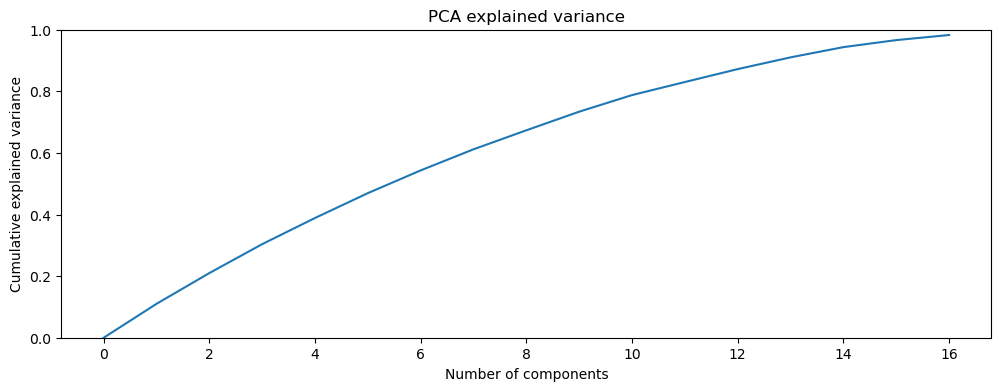

In [15]:
f, ax = plt.subplots(figsize=(12, 4))
ax.plot([0] + np.cumsum(pca.explained_variance_ratio_).tolist())
ax.set_title("PCA explained variance")
ax.set_xlabel("Number of components")
ax.set_ylim((0, 1))
ax.set_ylabel("Cumulative explained variance")

In [16]:
pca_df = pd.DataFrame(
    [(label_idx, instance_idx, *pca_coords)
     for (label_idx, instance_idx, _), pca_coords
     in zip(agg_src, all_trajectories_pca)],
     columns=["label_idx", "instance_idx"] + [f"pca_{i}" for i in range(pca.n_components_)])
pca_df["label"] = [state_space_spec.labels[label_idx] for label_idx in pca_df["label_idx"]]
pca_df = pca_df.set_index(["label", "instance_idx"])

In [17]:
first_phoneme = state_space_spec.cuts.xs("phoneme", level="level").groupby(["label", "instance_idx"]).head(1).description.rename("first_phoneme")
last_phoneme = state_space_spec.cuts.xs("phoneme", level="level").groupby(["label", "instance_idx"]).tail(1).description.rename("last_phoneme")
num_phonemes = state_space_spec.cuts.xs("phoneme", level="level").groupby(["label", "instance_idx"]).size().rename("num_phonemes")
num_syllables = state_space_spec.cuts.xs("syllable", level="level").groupby(["label", "instance_idx"]).size().rename("num_syllables")
meta = pd.concat([first_phoneme, last_phoneme, num_phonemes, num_syllables], axis=1)
pca_df = pd.merge(pca_df, meta, left_index=True, right_index=True)

pca_df = pca_df.reset_index()

In [18]:
pca_df = pd.merge(pca_df, word_freq_df["Lg10WF"], left_on="label", right_index=True)

In [19]:
pca_df["log_frequency_bin"] = pd.qcut(pca_df["Lg10WF"], 10, labels=False)

In [20]:
pca_df[[f"pca_{i}" for i in range(pca.n_components_)] + ["Lg10WF", "num_phonemes", "num_syllables"]].corr()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,Lg10WF,num_phonemes,num_syllables
pca_0,1.000000,-0.003068,-0.000532,0.003666,0.005689,0.008013,-0.011042,-0.006415,-0.005798,-0.001179,0.012720,-0.004205,-0.027940,-0.006360,-0.014673,-0.003848,0.172934,-0.199453,-0.066360
pca_1,-0.003068,1.000000,-0.007289,0.012336,0.011232,0.012597,-0.027539,0.010354,-0.002975,-0.012675,0.028512,0.008696,0.006262,-0.022216,-0.033070,0.021891,0.071923,0.004584,-0.049359
pca_2,-0.000532,-0.007289,1.000000,-0.017362,0.016379,0.004053,-0.002072,-0.012531,0.007016,0.008248,-0.014791,0.000791,-0.019611,0.010751,0.014934,-0.010535,0.158056,-0.343034,-0.350934
pca_3,0.003666,0.012336,-0.017362,1.000000,-0.009308,-0.004251,0.010481,-0.013354,0.008240,-0.002643,-0.026434,-0.000143,-0.001791,-0.003266,0.004130,-0.001976,-0.180408,0.261956,0.344987
pca_4,0.005689,0.011232,0.016379,-0.009308,1.000000,0.005308,0.016119,0.008617,-0.005508,0.004177,-0.006592,-0.016425,0.015847,0.015620,0.003734,-0.008598,-0.043631,-0.029326,-0.107979
pca_5,0.008013,0.012597,0.004053,-0.004251,0.005308,1.000000,0.002657,0.008635,-0.011900,0.007666,0.015470,-0.010925,-0.016251,-0.000372,-0.002404,0.011936,0.054263,-0.276715,-0.304865
pca_6,-0.011042,-0.027539,-0.002072,0.010481,0.016119,0.002657,1.000000,0.018554,-0.015057,-0.013208,0.009318,0.017303,0.039455,-0.016506,-0.018451,0.021188,-0.146226,0.291154,0.301683
pca_7,-0.006415,0.010354,-0.012531,-0.013354,0.008617,0.008635,0.018554,1.000000,-0.005572,-0.001783,0.014258,-0.004568,-0.039917,0.009079,0.007579,-0.011611,0.168701,-0.105238,-0.060199
pca_8,-0.005798,-0.002975,0.007016,0.008240,-0.005508,-0.011900,-0.015057,-0.005572,1.000000,-0.004397,0.012324,0.010182,-0.015555,-0.008552,-0.010369,-0.002648,0.093131,-0.042123,0.071001
pca_9,-0.001179,-0.012675,0.008248,-0.002643,0.004177,0.007666,-0.013208,-0.001783,-0.004397,1.000000,0.006072,0.002626,-0.006334,-0.014309,-0.000506,-0.012896,0.084809,-0.330216,-0.159630


In [21]:
pca_df["hyp_0a"] = pca_df.first_phoneme.isin(("CH", "SH", "K", "P", "T"))
pca_df["hyp_0b"] = pca_df.label.str.startswith(("exp", "exe", "exa", "exc", "enc", "ext", "aca"))
pca_df["hyp_0"] = pca_df.hyp_0a | pca_df.hyp_0b

# pca_df["hyp_1a"] = pca_df.last_phoneme.isin(("T", "D"))
pca_df["hyp_1b"] = pca_df.first_phoneme.isin(("M", "N", "OY", "Y", "Z"))
pca_df["hyp_1c"] = pca_df.last_phoneme.isin(("Z", "JH", "ER"))
pca_df["hyp_1"] = pca_df.hyp_1b | pca_df.hyp_1c

pca_df["hyp_2"] = pca_df.num_syllables  # better correlation than log-freq, and # phonemes

In [22]:
meta_cols = [col for col in pca_df.columns if col not in ["label", "instance_idx"] and not col.startswith("pca_")]
pca_type_df = pca_df.groupby(["label"] + meta_cols)[[f"pca_{i}" for i in range(pca.n_components_)]].agg(["mean", "std"]).reset_index()
pca_type_df.columns = ["_".join(col).strip("_") for col in pca_type_df.columns.values]

In [23]:
pca_type_df

,label,label_idx,first_phoneme,last_phoneme,num_phonemes,num_syllables,Lg10WF,log_frequency_bin,hyp_0a,hyp_0b,...,pca_11_mean,pca_11_std,pca_12_mean,pca_12_std,pca_13_mean,pca_13_std,pca_14_mean,pca_14_std,pca_15_mean,pca_15_std
0,abandon,4040,AH,N,7,3,2.6170,2,False,False,...,-0.377157,0.030440,-0.251201,0.053793,0.407075,0.053563,-0.069912,0.031660,0.051892,0.033261
1,abandoned,4752,AH,D,8,3,2.8319,3,False,False,...,-0.331217,0.065598,-0.176048,0.081488,0.302773,0.071885,-0.084325,0.041127,0.054327,0.044779
2,ability,2683,AH,IY,7,4,2.9917,3,False,False,...,-0.015793,0.072726,0.119173,0.055103,0.426874,0.062123,0.016553,0.056082,-0.009730,0.037996
3,able,947,EY,L,4,2,3.9115,7,False,False,...,0.020630,0.080039,0.127729,0.070037,0.186336,0.074296,0.051719,0.059937,-0.020658,0.064767
4,aboard,373,AH,D,5,2,3.1332,4,False,False,...,-0.241939,0.084057,-0.004274,0.083008,0.639893,0.045424,0.127711,0.088446,0.062489,0.038103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,yourself,1441,Y,F,7,2,4.3454,9,False,False,...,0.385443,0.021372,0.466797,0.043583,0.328287,0.066297,0.133695,0.030372,-0.086101,0.020858
4874,yourselves,4304,Y,Z,8,2,3.1703,4,False,False,...,0.351770,0.096082,0.396280,0.057736,0.279558,0.056813,-0.043752,0.086013,0.003285,0.052377
4875,youth,1128,Y,TH,3,1,2.9340,3,False,False,...,0.067490,0.050891,0.219458,0.048321,0.076470,0.048227,0.256097,0.064139,-0.193909,0.055988
4876,youthful,1129,Y,L,6,2,1.9031,0,False,False,...,0.153842,0.047821,0.231714,0.038051,0.060892,0.042858,0.249771,0.031127,-0.283269,0.038220


<Axes: xlabel='pca_0_mean', ylabel='pca_1_mean'>

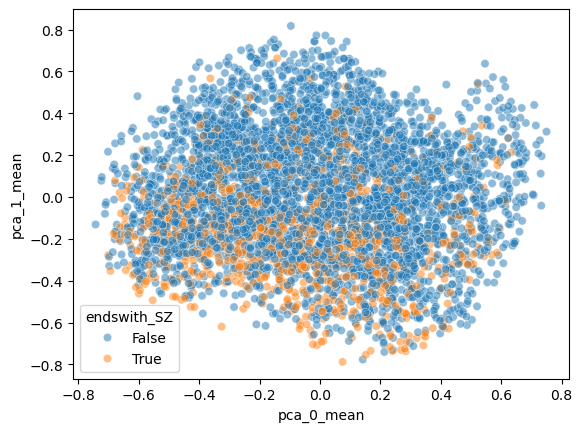

In [24]:
pca_type_df["endswith_SZ"] = pca_type_df.last_phoneme.isin(("S", "Z"))
pca_type_df["endswith_NG"] = pca_type_df.last_phoneme.isin(("NG",))
sns.scatterplot(data=pca_type_df, x="pca_0_mean", y="pca_1_mean", hue="endswith_SZ", alpha=0.5)

<Axes: xlabel='pca_2_mean', ylabel='pca_3_mean'>

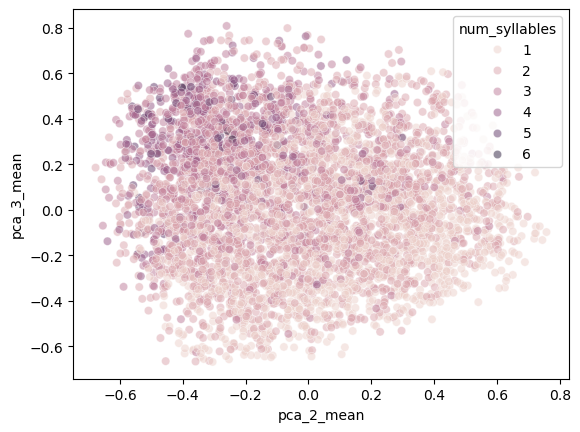

In [25]:
sns.scatterplot(data=pca_type_df, x="pca_2_mean", y="pca_3_mean", hue="num_syllables", alpha=0.5)

<Axes: xlabel='pca_0', ylabel='pca_1'>

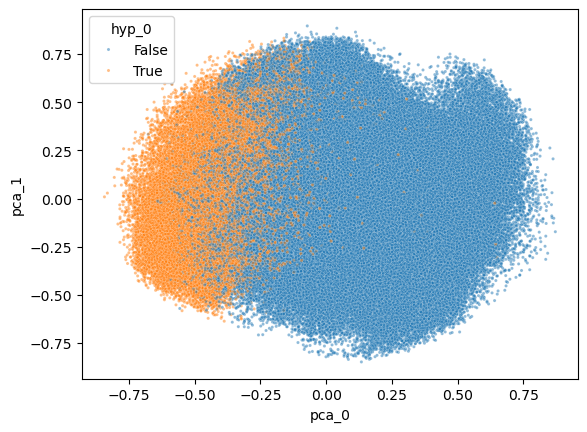

In [26]:
sns.scatterplot(data=pca_df, x="pca_0", y="pca_1", hue="hyp_0", s=5, alpha=0.5)

<Axes: xlabel='pca_2_mean', ylabel='pca_3_mean'>

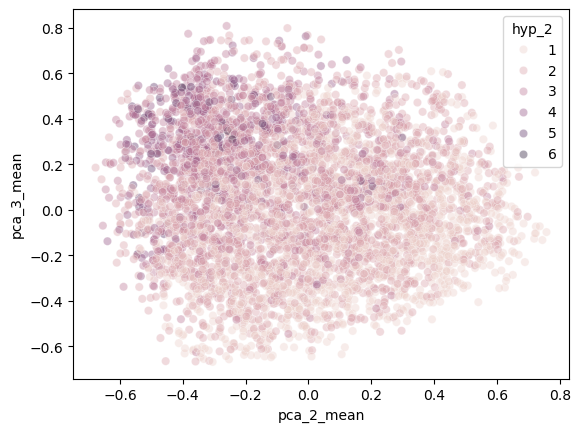

In [27]:
sns.scatterplot(data=pca_type_df, x="pca_2_mean", y="pca_3_mean", hue="hyp_2", alpha=0.4)

/tmp/ipykernel_3217448/2688140933.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sns.lineplot(data=pca_df.groupby("log_frequency_bin").apply(lambda xs: xs.groupby("label").apply(pc_volume).sort_values(ascending=False)).rename("pc_volume").reset_index(),
/tmp/ipykernel_3217448/2688140933.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sns.lineplot(data=pca_df.groupby("log_frequency_bin").apply(lambd

<Axes: xlabel='log_frequency_bin', ylabel='pc_volume'>

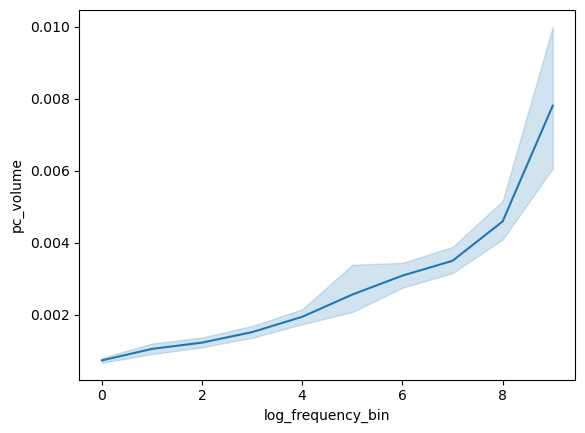

In [40]:
def pc_volume(rows):
    rows = rows[[f"pca_{i}" for i in range(min(4, pca.n_components_))]]
    from scipy.spatial import ConvexHull
    hull = ConvexHull(rows.values)
    return hull.volume

sns.lineplot(data=pca_df.groupby("log_frequency_bin").apply(lambda xs: xs.groupby("label").apply(pc_volume).sort_values(ascending=False)).rename("pc_volume").reset_index(),
             x="log_frequency_bin", y="pc_volume")

/tmp/ipykernel_3217448/563613876.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pc_volume_df = pca_df.groupby(["label", "Lg10WF"]).apply(pc_volume).rename("pc_volume").reset_index()


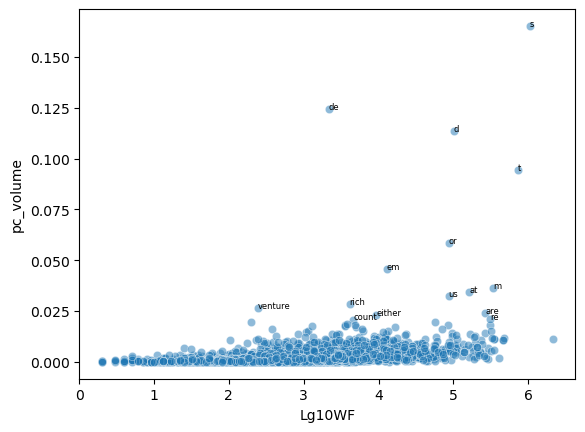

In [49]:
pc_volume_df = pca_df.groupby(["label", "Lg10WF"]).apply(pc_volume).rename("pc_volume").reset_index()
ax = sns.scatterplot(data=pc_volume_df, x="Lg10WF", y="pc_volume", alpha=0.5)

for _, row in pc_volume_df[pc_volume_df.pc_volume >= 0.02].iterrows():
    ax.text(row.Lg10WF, row.pc_volume, row.label, size=6)

/tmp/ipykernel_3201245/2125795966.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ax = sns.lineplot(data=pca_df.groupby("log_frequency_bin").apply(lambda xs: xs.groupby("label")[[f"pca_{i}" for i in range(16)]].std().mean(axis=0)).reset_index().melt(id_vars="log_frequency_bin"),
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning

Text(0.5, 1.0, 'Variance along PCA components by log frequency bin')

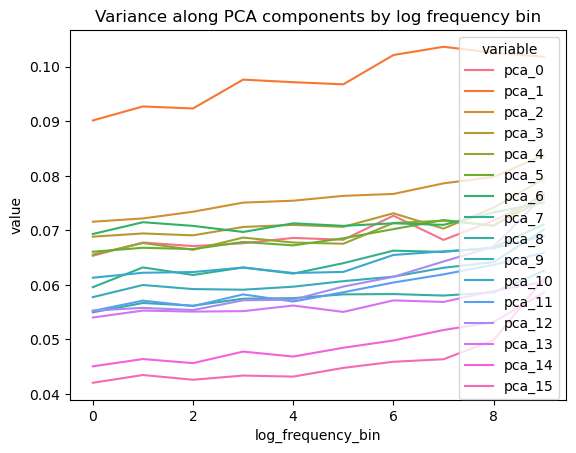

In [27]:
# relationship between variance along a PC and word frequency
ax = sns.lineplot(data=pca_df.groupby("log_frequency_bin").apply(lambda xs: xs.groupby("label")[[f"pca_{i}" for i in range(16)]].std().mean(axis=0)).reset_index().melt(id_vars="log_frequency_bin"),
             x="log_frequency_bin", y="value", hue="variable")
ax.set_title("Variance along PCA components by log frequency bin")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


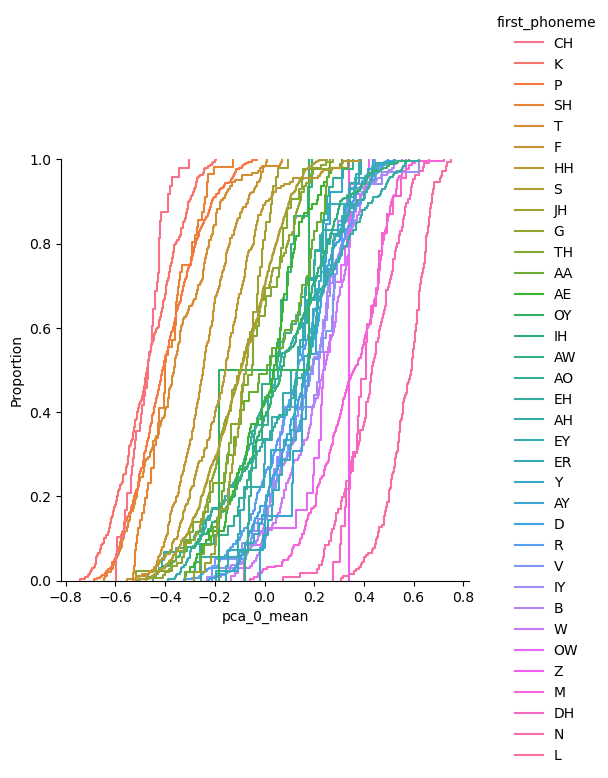

In [28]:
sns.displot(data=pca_type_df, x="pca_0_mean", hue="first_phoneme", kind="ecdf",
            hue_order=pca_df.groupby("first_phoneme").pca_0.mean().sort_values().index)

### study PC 1

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


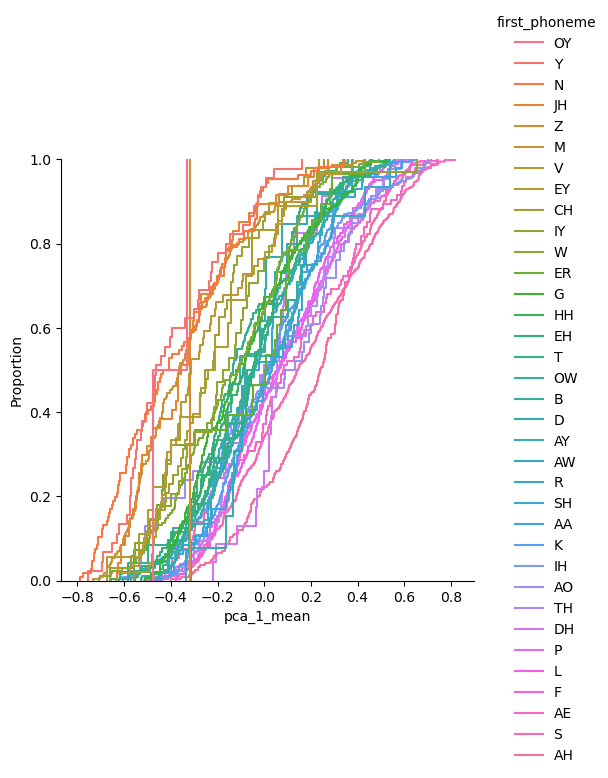

In [29]:
sns.displot(data=pca_type_df, x="pca_1_mean", hue="first_phoneme", kind="ecdf",
            hue_order=pca_type_df.groupby("first_phoneme").pca_1_mean.mean().sort_values().index)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


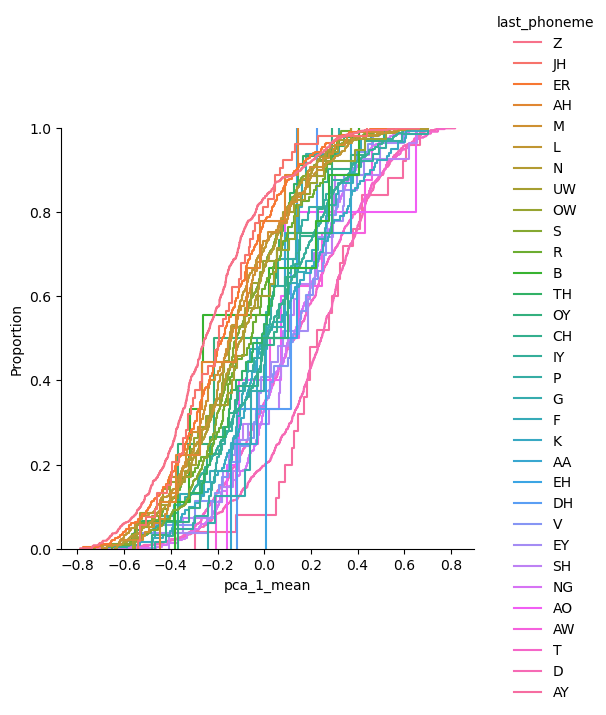

In [30]:

sns.displot(data=pca_type_df, x="pca_1_mean", hue="last_phoneme", kind="ecdf",
            hue_order=pca_type_df.groupby("last_phoneme").pca_1_mean.mean().sort_values().index)

<Axes: xlabel='pca_0_mean', ylabel='pca_1_mean'>

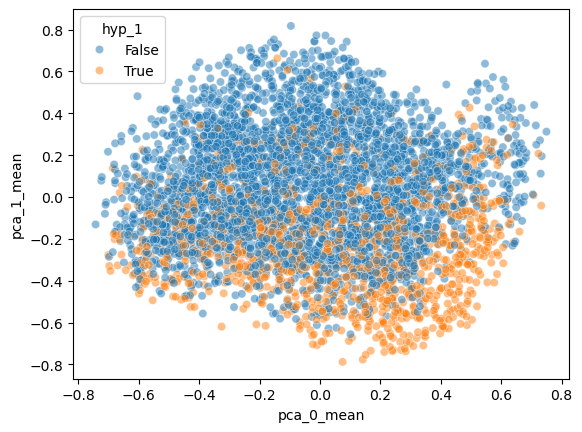

In [31]:
sns.scatterplot(data=pca_type_df, x="pca_0_mean", y="pca_1_mean", hue="hyp_1", alpha=0.5)

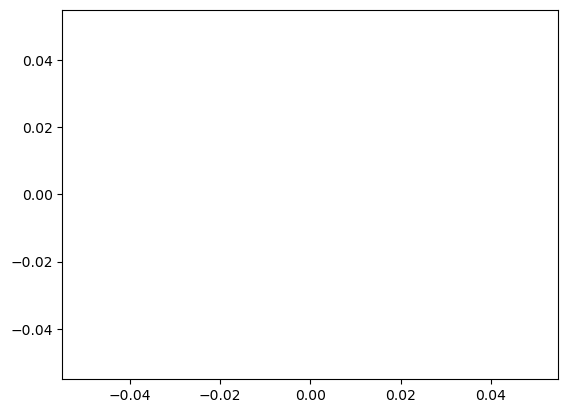

In [32]:
sns.scatterplot(data=pca_type_df[(pca_type_df.pca_0_mean > 1) & (pca_type_df.pca_1_mean > 2)],
                x="pca_0_mean", y="pca_1_mean", alpha=0.5)
for label, row in pca_type_df[(pca_type_df.pca_0_mean > 1) & (pca_type_df.pca_1_mean > 2)].iterrows():
    plt.text(row.pca_0_mean, row.pca_1_mean, row.label, fontsize=6)